# day 27 : From EDA to the Top

https://www.kaggle.com/gaborfodor/from-eda-to-the-top-lb-0-367

## Introduction

뉴욕 택시 여행의 총 승차 기간을 예측하는 모델을 구축해야한다. 여기선 변수 추출에 더 초점을 맞추려고 한다.

주요 목표는 주어진 커널 제한으로 XGB에 대해 가능한 최상의 변수 셋을 만드는 것이다.

이 간단한 노트북으로
- 데이터셋 탐색
- 59개의 유용한 변수 추출
- 간단한 80-20 train-validation 셋 생성
- trian XGBregressor
- 변수 중요도 분석
- 테스트셋 점수 매기기 및 제출
- 추가 개선사항에 대해 XGB 파라미터 검색 결과 확인

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
from datetime import timedelta
import datetime as dt
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
import warnings
warnings.filterwarnings('ignore')

## First week progress

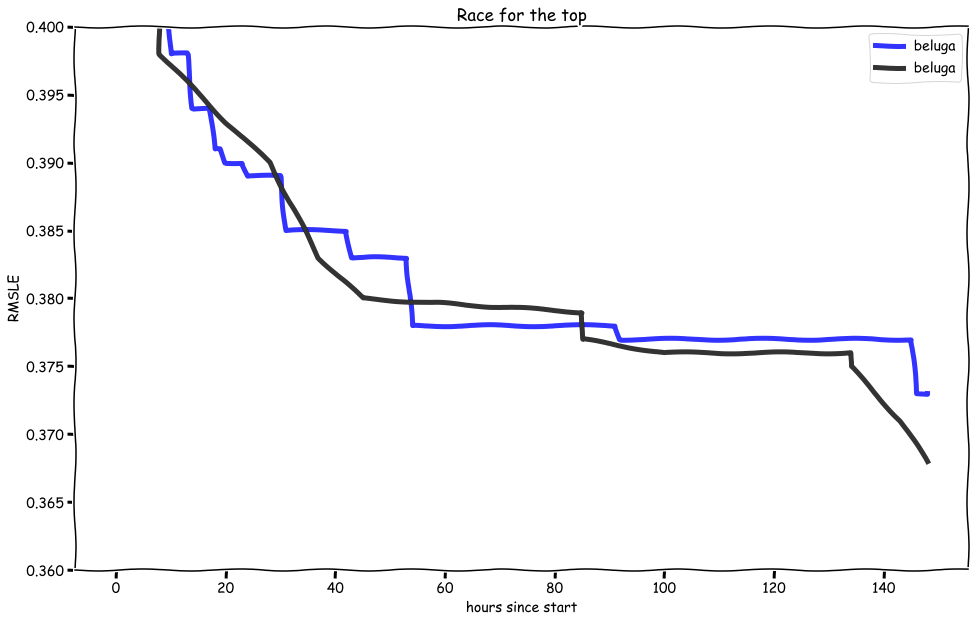

In [5]:
beluga = pd.DataFrame({'since_start_hour': [8.0, 8.0, 20.0, 28.0, 37.0, 45.0, 85.0, 85.0, 100.0, 134.0, 134.0, 143.0, 148.0],
                      'Score': [ 0.400,  0.398,  0.393,  0.390,  0.383,  0.380,  0.379,  0.377,  0.376,  0.376,  0.375,  0.371,  0.368]})
others = pd.DataFrame({'since_start_hour': [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,68,69,70,71,72,73,74,75,76,77,78,79,80,81,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148],
                      'BestScore': [.452,.452,.452,.452,.452,.452,.421,.421,.421,.406,.398,.398,.398,.398,.394,.394,.394,.394,.391,.391,.390,.390,.390,.390,.389,.389,.389,.389,.389,.389,.389,.385,.385,.385,.385,.385,.385,.385,.385,.385,.385,.385,.385,.383,.383,.383,.383,.383,.383,.383,.383,.383,.383,.383,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.373,.373,.373]})
with plt.xkcd():
    # 이 figure은 XKCD-style에 있을 것
    fig, ax = plt.subplots()
    ax.plot(others.since_start_hour.values, others.BestScore.values, 'b', alpha=0.8, lw=5, label='beluga')
    ax.plot(beluga.since_start_hour.values, beluga.Score.values, 'k', alpha=0.8, lw=5, label='beluga')
    ax.set_ylim(0.36, 0.4)
    ax.legend(loc=0)
    ax.set_xlabel('hours since start')
    ax.set_ylabel('RMSLE')
    ax.set_title('Race for the top')
    plt.show()

## Data understanding

In [6]:
np.random.seed(1987)
N = 100000  # plot에서 샘플 행 개수
t0 = dt.datetime.now()
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
sample_submission = pd.read_csv('../input/sample_submission.csv')

데이터파일을 확인해보자. 데이터 설명에 따라 다음 열을 찾는다.
- id : 각 여행의 고유 식별자
- vendor_id : 여행 레코드와 관련된 제공자를 나타내는 코드
- pickup_datetime : 미터기가 작동된 날짜와 시간
- dropoff_datetime : 미터기가 작동되지 않은 날짜와 시간
- passenger_count : 차량 내 승객 수 (운전자가 값 입력)
- pickup_longitude : 미터기가 작동된 경도
- pickup_latitude : 미터기가 작동된 위도
- dropoff_longtitude : 미터기가 작동되지 않은 경도
- dropoff_latitude : 미터기가 작동되지 않은 위도
- store_and_fwd_flag : 차량이 서버에 연결되어있지 않아 vendor에 전송하기 전 여행 레코드가 차량 메모리에 저장되었는지 여부 (Y=저장 및 여행 계속, N=저장 안 되고 여행 계속)
- trip_duration : 여행 기간(초)

dropoff_datetime과 trip_duration은 train 셋에만 있다.

In [7]:
print('We have {} training rows and {} test rows.'.format(train.shape[0], test.shape[0]))
print('We have {} training columns and {} test columns.'.format(train.shape[1], test.shape[1]))
train.head(2)

We have 1458644 training rows and 625134 test rows.
We have 11 training columns and 9 test columns.


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663


In [8]:
print('Id is unique.') if train.id.nunique() == train.shape[0] else print('oops')
print('Train and test sets are distinct.') if len(np.intersect1d(train.id.values, test.id.values))==0 else print('oops')
print('We do not need to worry about missing values.') if train.count().min()==train.shape[0] and test.count().min()==test.shape[0] else print('oops')
print('The store_and_fwd_flag has only tow values {}.'.format(str(set(train.store_and_fwd_flag.unique()) | set(test.store_and_fwd_flag.unique()))))

Id is unique.
Train and test sets are distinct.
We do not need to worry about missing values.
The store_and_fwd_flag has only tow values {'Y', 'N'}.


In [9]:
train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)
test['pickup_datetime'] = pd.to_datetime(test.pickup_datetime)
train.loc[:,'pickup_date'] = train['pickup_datetime'].dt.date
test.loc[:,'pickup_date'] = test['pickup_datetime'].dt.date

train['dropoff_datetime'] = pd.to_datetime(train.dropoff_datetime)
train['store_and_fwd_flag'] = 1 * (train.store_and_fwd_flag.values=='Y')
test['store_and_fwd_flag'] = 1 * (test.store_and_fwd_flag.values=='Y')

train['check_trip_duration'] = (train['dropoff_datetime'] - train['pickup_datetime']).map(lambda x: x.total_seconds())
duration_difference = train[np.abs(train['check_trip_duration'].values - train['trip_duration'].values)>1]
print('Trip_duration and datetimes are ok.') if len(duration_difference[['pickup_datetime','dropoff_datetime','trip_duration','check_trip_duration']])==0 else print('Ooops.')

Trip_duration and datetimes are ok.


In [10]:
train['trip_duration'].max() // 3600  ### 초단위를 60*60로 나눔. 시간단위.

979

trip_duration 최댓값은 ~1000 시간임을 알 수 있다. 다행히 평가지표는 RMSE가 아니라 RMSLE다. 이상치는 문제가 덜 될 것이다. target 레이블을 로그변환하고 학습 중 RMSE를 사용할 수 있다.

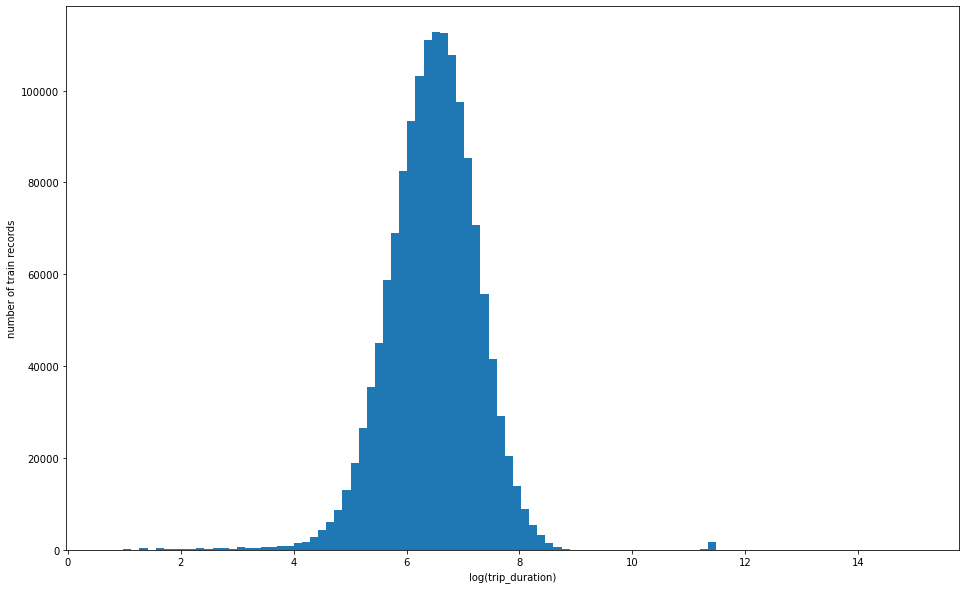

In [11]:
train['log_trip_duration'] = np.log(train['trip_duration'].values+1)
plt.hist(train['log_trip_duration'].values, bins=100)
plt.xlabel('log(trip_duration)')
plt.ylabel('number of train records')
plt.show()

## Validation Strategy

우선 train test split을 확인해보자. 이는 검증 전략을 결정하고 feature engineering에 대한 아이디어를 제공한다.

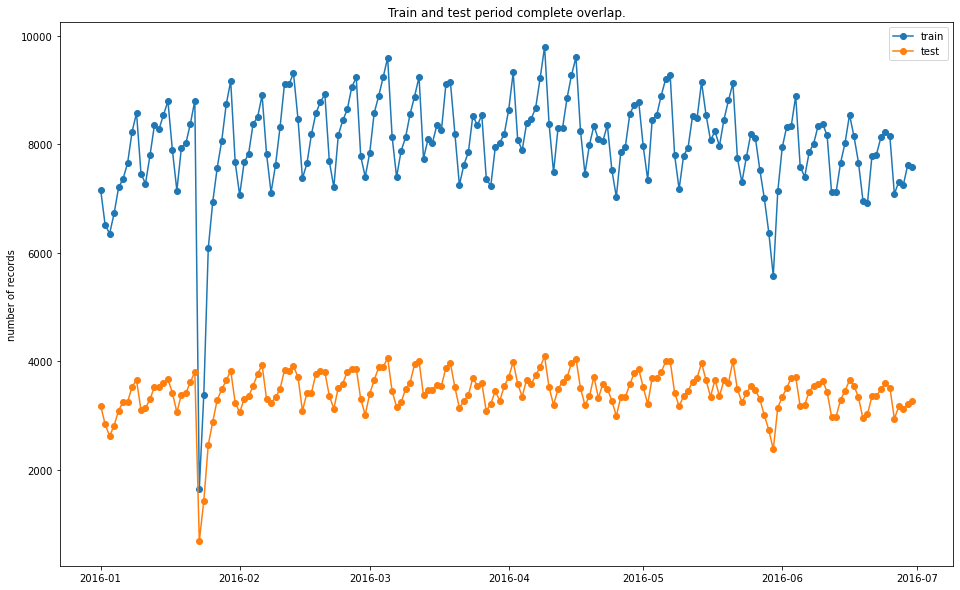

In [12]:
plt.plot(train.groupby('pickup_date').count()[['id']], 'o-', label='train')
plt.plot(test.groupby('pickup_date').count()[['id']], 'o-', label='test')
plt.title('Train and test period complete overlap.')
plt.legend(loc=0)
plt.ylabel('number of records')
plt.show()

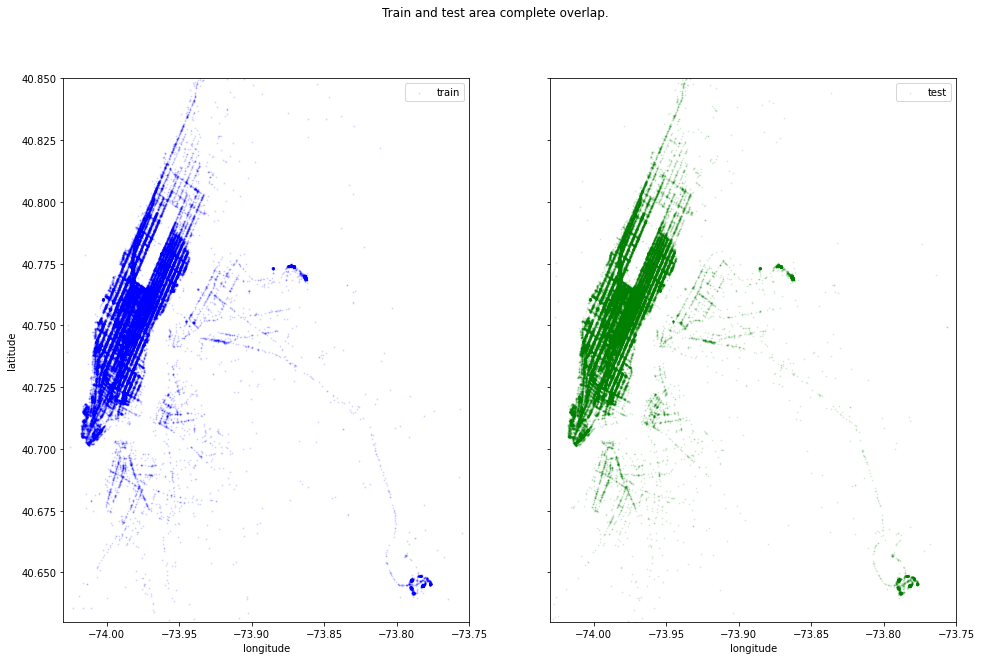

In [13]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True)
ax[0].scatter(train['pickup_longitude'].values[:N], train['pickup_latitude'].values[:N],
             color='blue', s=1, label='train', alpha=0.1)
ax[1].scatter(test['pickup_longitude'].values[:N], test['pickup_latitude'].values[:N],
             color='green', s=1, label='test', alpha=0.1)
fig.suptitle('Train and test area complete overlap.')
ax[0].legend(loc=0)
ax[0].set_ylabel('latitude')
ax[0].set_xlabel('longitude')
ax[1].set_xlabel('longitude')
ax[1].legend(loc=0)
plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.show()

이 경우 train과 test 분할은 랜덤인 것 같아 보인다. 이는 전체 데이터셋에 적용할 비지도학습과 변수 추출을 사용할 수 있게 한다.

## Feature Extraction

### PCA

PCA를 사용해 경도와 위도 좌표를 변환한다. 이 경우 2D->2D 변환이므로 차원 축소에 관한 것이 아니다. rotation은 의사결정나무 분할에 도움이 될 수 있다.

In [14]:
coords = np.vstack((train[['pickup_latitude','pickup_longitude']].values,
                   train[['dropoff_latitude','dropoff_longitude']].values,
                   test[['pickup_latitude','pickup_longitude']].values,
                   test[['dropoff_latitude','dropoff_longitude']].values))  ### 좌표

pca = PCA().fit(coords)
train['pickup_pca0'] = pca.transform(train[['pickup_latitude','pickup_longitude']])[:,0]
train['pickup_pca1'] = pca.transform(train[['pickup_latitude','pickup_longitude']])[:,1]
train['dropoff_pca0'] = pca.transform(train[['dropoff_latitude','dropoff_longitude']])[:,0]
train['dropoff_pca1'] = pca.transform(train[['dropoff_latitude','dropoff_longitude']])[:,1]
test['pickup_pca0'] = pca.transform(test[['pickup_latitude','pickup_longitude']])[:,0]
test['pickup_pca1'] = pca.transform(test[['pickup_latitude','pickup_longitude']])[:,1]
test['dropoff_pca0'] = pca.transform(test[['dropoff_latitude','dropoff_longitude']])[:,0]
test['dropoff_pca1'] = pca.transform(test[['dropoff_latitude','dropoff_longitude']])[:,1]

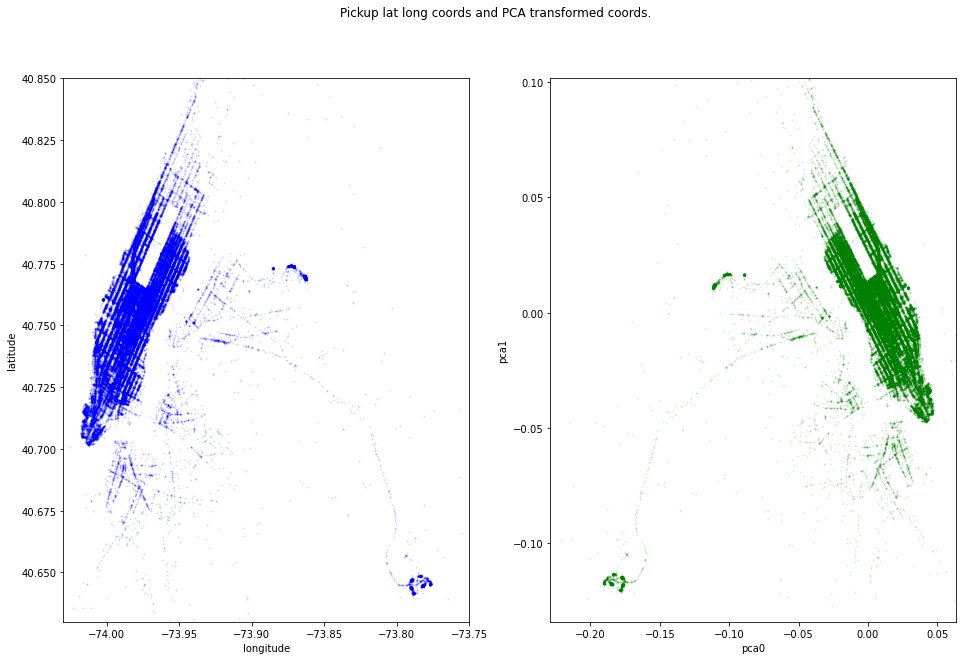

In [15]:
fig, ax = plt.subplots(ncols=2)
ax[0].scatter(train['pickup_longitude'].values[:N], train['pickup_latitude'].values[:N], color='blue',s=1,alpha=0.1)
ax[1].scatter(train['pickup_pca0'].values[:N], train['pickup_pca1'].values[:N], color='green',s=1,alpha=0.1)
fig.suptitle('Pickup lat long coords and PCA transformed coords.')
ax[0].set_ylabel('latitude')
ax[0].set_xlabel('longitude')
ax[1].set_xlabel('pca0')
ax[1].set_ylabel('pca1')
ax[0].set_xlim(city_long_border)
ax[0].set_ylim(city_lat_border)
pca_borders = pca.transform([[x,y] for x in city_lat_border for y in city_long_border])
ax[1].set_xlim(pca_borders[:,0].min(), pca_borders[:,0].max())
ax[1].set_ylim(pca_borders[:,1].min(), pca_borders[:,1].max())
plt.show()

### Distance

픽업 지점과 하차 지점 사이 거리(km)를 계산해보자. 현재 Haversine이 사용된 geopy는 원하는 경우 또다른 heuristics(vincenty() 혹은 great_circle())를 갖는다. 택시는 운행되지 않고 우리는 뉴욕에 있으므로 맨해튼거리(L1)도 확인할 수 있다.

pd.DataFrame.apply()는 너무 느려서 haversine 함수가 배열을 처리하기 위해 다시 쓰일 수 없다. 또한 경로의 중간을 변수로 추가한다.

In [16]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    ### 180 degree = π radian  |  1 radian = 180 degree/ π
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat*0.5)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(lng*0.5)**2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def dummy_manhattan_distance(lat, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

train.loc[:,'distance_haversine'] = haversine_array(train['pickup_latitude'].values, train['pickup_longitude'].values,
                                                   train['dropoff_latitude'].values, train['dropoff_longitude'].values)
train.loc[:,'distance_dummy_manhattan'] = dummy_manhattan_disance(train['pickup_latitude'].values, train['pickup_longitude'].values,
                                                                 train['dropoff_latitude'].values, train['dropoff_longitude'].values)
train.loc[:,'direction'] = bearing_array(train['pickup_latitude'].values, train['pickup_longitude'].values, 
                                          train['dropoff_latitude'].values, train['dropoff_longitude'].values)
train.loc[:,'pca_manhattan'] = np.abs(train['dropoff_pca1'] - train['pickup_pca1']) + np.abs(train['dropoff_pca0'] - train['pickup_pca0'])


test.loc[:,'distance_haversine'] = haversine_array(test['pickup_latitude'].values, test['pickup_longitude'].values, 
                                                    test['dropoff_latitude'].values, test['dropoff_longitude'].values)
test.loc[:,'distance_dummy_manhattan'] = dummy_manhattan_distance(test['pickup_latitude'].values, test['pickup_longitude'].values, 
                                                                   test['dropoff_latitude'].values, test['dropoff_longitude'].values)
test.loc[:,'direction'] = bearing_array(test['pickup_latitude'].values, test['pickup_longitude'].values, 
                                         test['dropoff_latitude'].values, test['dropoff_longitude'].values)
test.loc[:,'pca_manhattan'] = np.abs(test['dropoff_pca1'] - test['pickup_pca1']) + np.abs(test['dropoff_pca0'] - test['pickup_pca0'])


train.loc[:,'center_latitude'] = (train['pickup_latitude'].values + train['dropoff_latitude'].values) / 2
train.loc[:,'center_longitude'] = (train['pickup_longitude'].values + train['dropoff_longitude'].values) / 2
test.loc[:,'center_latitude'] = (test['pickup_latitude'].values + test['dropoff_latitude'].values) / 2
test.loc[:,'center_longitude'] = (test['pickup_longitude'].values + test['dropoff_longitude'].values) / 2

NameError: name 'dummy_manhattan_disance' is not defined